# Calcium Deconvolution

In this lab you'll write your own code for demixing and deconvolving calcium imaging videos. Demixing refers to the problem of identifying potentially overlapping neurons in the video and separating their fluorescence traces. Deconvolving refers to taking those traces and finding the times of spiking activity, which produce exponentially decaying transients in fluorescence. We'll frame it as a constrained and (partially) non-negative matrix factorization problem, inspired by the CNMF model of Pnevmatikakis et al, 2016, which is implemented in [CaImAn](https://github.com/flatironinstitute/CaImAn) (Giovannucci et al, 2019). More details and further references are in the course notes. We'll use [CVXpy](https://www.cvxpy.org/) to solve the convex optimization problems at the hard of this approach.

**References**
- Pnevmatikakis, Eftychios A., Daniel Soudry, Yuanjun Gao, Timothy A. Machado, Josh Merel, David Pfau, Thomas Reardon, et al. 2016. “Simultaneous Denoising, Deconvolution, and Demixing of Calcium Imaging Data.” Neuron 89 (2): 285–99.
[link](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4881387/)
- Giovannucci, Andrea, Johannes Friedrich, Pat Gunn, Jérémie Kalfon, Brandon L. Brown, Sue Ann Koay, Jiannis Taxidis, et al. 2019. “CaImAn an Open Source Tool for Scalable Calcium Imaging Data Analysis.” eLife. [link](http://dx.doi.org/10.7554/eLife.38173)





## Setup

In [16]:
%%capture
try:
    import jaxtyping
except ImportError:
    !pip install jaxtyping

from typing import Optional, Any, Dict, Union, Tuple
from jaxtyping import Float, Int, Array
from torch import Tensor

In [17]:
import torch
import torch.nn.functional as F
import torch.distributions as dist
import numpy as np

# We'll use a few SciPy functions too
import scipy.sparse
from scipy.signal import butter, sosfilt
from scipy.ndimage import gaussian_filter
from skimage.feature import peak_local_max

# We'll use CVXpy to solve convex optimization problems
import cvxpy as cvx

# Plotting stuff
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from matplotlib.patches import Circle
import seaborn as sns

# Helpers
from tqdm.auto import trange
import warnings

In [18]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### Download example data

This demo data was contributed by Sue Ann Koay and David Tank (Princeton University).
It is also used in the CaImAn demo notebook.
We used CaImAn and NoRMCorr to correct for motion artifacts.

In [19]:
!wget -nc https://github.com/slinderman/ml4nd/raw/refs/heads/main/data/02_calcium_imaging/lab02_data.pt

File ‘lab02_data.pt’ already there; not retrieving.



In [20]:
# Load the data
data = torch.load("lab02_data.pt")
height, width, num_frames = data.shape

# Set some constants
FPS = 30                        # frames per second in the movie
NEURON_WIDTH = 10               # approximate width (in pixels) of a neuron
GCAMP_TIME_CONST_SEC = 0.300    # reasonable guess for calcium decay time const.

### Helper functions for plotting

In [21]:
#@title Helper functions for movies and plotting { display-mode: "form" }
from matplotlib import animation
from IPython.display import HTML
from tempfile import NamedTemporaryFile
import base64

# Set some plotting defaults
sns.set_context("talk")

# initialize a color palette for plotting
palette = sns.xkcd_palette(["windows blue",
                            "red",
                            "medium green",
                            "dusty purple",
                            "orange",
                            "amber",
                            "clay",
                            "pink",
                            "greyish"])

_VIDEO_TAG = """<video controls>
 <source src="data:video/x-m4v;base64,{0}" type="video/mp4">
 Your browser does not support the video tag.
</video>"""

def _anim_to_html(anim: animation.FuncAnimation,
                  fps: int = 20) -> str:
    """
    Convert a Matplotlib animation object to an HTML video snippet
    with an embedded base64-encoded video.

    Parameters:
    -----------
    anim : matplotlib.animation.FuncAnimation
        The Matplotlib animation object to encode.
    fps : int, optional
        Frames per second to use when encoding the animation. Default is 20.

    Returns:
    --------
    str
        An HTML string containing the video tag with the encoded video.
    """
    if not hasattr(anim, '_encoded_video'):
        with NamedTemporaryFile(suffix='.mp4') as f:
            anim.save(f.name, fps=fps, extra_args=['-vcodec', 'libx264'])
            video = open(f.name, "rb").read()
        anim._encoded_video = base64.b64encode(video)

    return _VIDEO_TAG.format(anim._encoded_video.decode('ascii'))

def _display_animation(anim: animation.FuncAnimation,
                       fps: int = 30,
                       start: int = 0,
                       stop: Optional[int] = None) -> HTML:
    """
    Display a Matplotlib animation by converting it to an HTML video snippet
    and closing its figure.

    Parameters:
    -----------
    anim : matplotlib.animation.FuncAnimation
        The animation object to display.
    fps : int, optional
        Frames per second for the displayed animation. Default is 30.
    start : int, optional
        Starting frame index (currently not used #TODO). Default is 0.
    stop : Optional[int], optional
        Ending frame index (currently not used #TODO). Default is None.

    Returns:
    --------
    IPython.display.HTML
        An HTML snippet containing the video for display.
    """
    plt.close(anim._fig)
    return HTML(_anim_to_html(anim, fps=fps))

def play(movie: Int[Tensor, "height width num_frames"],
         fps: int = FPS,
         speedup: int = 1,
         fig_height: int = 6):
    """
    Create an animation from a movie tensor and return
    an HTML snippet for embedding.

    Parameters:
    -----------
    movie : torch.Tensor
        A 3D tensor with shape (height, width, num_frames) for the movie frames.
    fps : int, optional
        Frames per second of the movie. Default is the global FPS constant.
    speedup : int, optional
        Factor to speed up the animation. Default is 1 (real-time).
    fig_height : int, optional
        Height of the figure (in inches) for the plot. Default is 6.

    Returns:
    --------
    IPython.display.HTML
        An HTML video snippet displaying the animation.

    Notes:
    ------
    This function uses Matplotlib's FuncAnimation to create the animation
    and embeds it as an HTML video.
    """
    # First set up the figure, the axis, and the plot element we want to animate
    Py, Px, T = movie.shape
    fig, ax = plt.subplots(1, 1, figsize=(fig_height * Px/Py, fig_height))
    im = plt.imshow(movie[..., 0], interpolation='None', cmap=plt.cm.gray)
    tx = plt.text(0.75, 0.05, 't={:.3f}s'.format(0),
                  color='white',
                  fontdict=dict(size=12),
                  horizontalalignment='left',
                  verticalalignment='center',
                  transform=ax.transAxes)
    plt.axis('off')

    def animate(i: int):
        """
        Update function for FuncAnimation.

        Parameters:
        -----------
        i : int
            The frame index.

        Returns:
        --------
        tuple
            A tuple containing the modified image;
            used for efficient animation updates.
        """
        im.set_data(movie[..., i * speedup])
        tx.set_text("t={:.3f}s".format(i * speedup / fps))
        return im,

    # call the animator.  blit=True means only re-draw the parts that changed.
    anim = animation.FuncAnimation(fig, animate,
                                   frames=T // speedup,
                                   interval=1,
                                   blit=True)
    plt.close(anim._fig)

    # return an HTML video snippet
    print("Preparing animation. This may take a minute...")
    return HTML(_anim_to_html(anim, fps=30))

def plot_problem_1d(local_correlations: Float[torch.Tensor, "height width"],
                    filtered_correlations: Float[torch.Tensor, "height width"],
                    peaks: Int[torch.Tensor, "num_peaks 2"]) -> None:
    """
    Plot local correlations, filtered correlations,
    and candidate neurons side-by-side.

    Parameters
    ----------
    local_correlations : torch.Tensor
        2D tensor representing local correlation values,
        with shape (height, width).
    filtered_correlations : torch.Tensor
        2D tensor representing filtered correlation values,
        with shape (height, width).
    peaks : torch.Tensor
        Tensor of shape (num_peaks, 2) where each row is [y, x] coordinates
        for peak locations.

    Returns
    -------
    None

    Notes
    -----
    The function displays three panels and overlays circles and labels
    on the candidate neuron panel.
    """
    def _plot_panel(ax: plt.Axes,
                    im: Float[torch.Tensor, "height width"],
                    title: str) -> None:
        """
        Plot an individual panel with an image and a colorbar.

        Parameters
        ----------
        ax : matplotlib.axes.Axes
            The axis on which to plot.
        im : torch.Tensor
            The image data to display, with shape (height, width).
        title : str
            Title for the panel.
        """
        h = ax.imshow(im, cmap="Greys_r")
        ax.set_title(title)
        ax.set_xlim(0, width)
        ax.set_ylim(height, 0)
        ax.set_axis_off()

        # add a colorbar of the same height
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad="2%")
        plt.colorbar(h, cax=cax)

    fig, axs = plt.subplots(1, 3, figsize=(15, 6))
    _plot_panel(axs[0], local_correlations, "local correlations")
    _plot_panel(axs[1], filtered_correlations, "filtered correlations")
    _plot_panel(axs[2], local_correlations, "candidate neurons")

    # Draw circles around the peaks
    for n, yx in enumerate(peaks):
        y, x = yx
        axs[2].add_patch(Circle((x, y),
                                radius=NEURON_WIDTH/2,
                                facecolor='none',
                                edgecolor='red',
                                linewidth=1))

        axs[2].text(x, y, "{}".format(n),
                    horizontalalignment="center",
                    verticalalignment="center",
                    fontdict=dict(size=10, weight="bold"),
                    color='r')

def plot_problem_2(traces: Float[torch.Tensor, "num_neurons num_frames"],
                     denoised_traces: Float[torch.Tensor, "num_neurons num_frames"],
                     amplitudes: Float[torch.Tensor, "num_neurons num_frames"]) -> None:
    """
    Plot raw and denoised fluorescence traces for neurons
    along with amplitude markers.

    Parameters
    ----------
    traces : torch.Tensor
        2D tensor of raw fluorescence traces with shape (num_neurons, num_frames).
    denoised_traces : torch.Tensor
        2D tensor of denoised fluorescence traces, same shape as 'traces'.
    amplitudes : torch.Tensor
        2D tensor of estimated amplitudes, same shape as 'traces'.

    Returns
    -------
    None

    Notes
    -----
    Normalizes the traces by their 99.5th percentile,
    offsets the traces for clarity, and highlights amplitude markers.
    """
    num_neurons, num_frames = traces.shape

    # Plot the traces and our denoised estimates
    scale = torch.quantile(traces, .995, dim=1, keepdims=True)
    offset = -torch.arange(num_neurons)

    # Plot points at the time frames where the (normalized) amplitudes are > 0.05
    sparse_amplitudes = amplitudes / scale
    # sparse_amplitudes = torch.isclose(sparse_amplitudes, 0, atol=0.05)
    sparse_amplitudes[sparse_amplitudes < 0.05] = torch.nan
    sparse_amplitudes[sparse_amplitudes > 0.05] = 0.0

    plt.figure(figsize=(12, 8))
    plt.plot((traces / scale).T + offset , color=palette[0], lw=1, alpha=0.5)
    plt.plot((denoised_traces / scale).T + offset, color=palette[0], lw=2)
    plt.plot((sparse_amplitudes).T + offset, color=palette[1], marker='o', markersize=2)
    plt.xlabel("time (frames)")
    plt.xlim(0, num_frames)
    plt.ylabel("neuron")
    plt.yticks(-torch.arange(0, num_neurons, step=5),
               labels=torch.arange(0, num_neurons, step=5).numpy())
    plt.ylim(-num_neurons, 2)
    plt.title("raw and denoised fluorescence traces")


def plot_problem_3(flat_data: Any,
                     params: Dict[str, torch.Tensor],
                     hypers: Any,
                     plot_bkgd: bool = True,
                     indices: Optional[Int[torch.Tensor, "num_indices"]] = None) -> None:
    """
    Plot neuron footprints and their corresponding fluorescence traces.

    Parameters
    ----------
    flat_data : Any
        Data used for plotting (currently not used within the function).
    params : dict[str, torch.Tensor]
        Dictionary containing model parameters with the following keys:
          - 'footprints': Neuron footprints, expected to be reshaped to (-1, height, width).
          - 'bkgd_footprint': Background footprint reshaped to (height, width).
          - 'traces': Fluorescence traces for each neuron.
          - 'bkgd_trace': Background trace.
    hypers : Any
        Hyperparameters related to the model (not directly used in plotting).
    plot_bkgd : bool, optional
        Whether to include background plots. Default is True.
    indices : Optional[torch.Tensor], optional
        Indices of neurons to plot; if None, all neurons are plotted.

    Returns
    -------
    None

    Notes
    -----
    Generates a separate plot for each neuron (and background, if requested) showing both the spatial footprint
    and its corresponding fluorescence trace.
    """
    U = params["footprints"].reshape(-1, height, width)
    u0 = params["bkgd_footprint"].reshape(height, width)
    C = params["traces"]
    c0 = params["bkgd_trace"]
    N, T = C.shape

    if indices is None:
        indices = torch.arange(N)

    def _plot_factor(footprint: Float[torch.Tensor, "height width"],
                     trace: Float[torch.Tensor, "num_frames"],
                     title: str) -> None:
        """
        Plot a neuron's footprint and its corresponding fluorescence trace.

        Parameters
        ----------
        footprint : torch.Tensor
            2D tensor representing the spatial footprint of a neuron,
            with shape (height, width).
        trace : torch.Tensor
            1D tensor containing the fluorescence trace over time,
            with shape (num_frames,).
        title : str
            Title for the subplot.
        """
        fig, ax1 = plt.subplots(1, 1, figsize=(12, 6))
        vlim = abs(footprint).max()
        h = ax1.imshow(footprint, vmin=-vlim, vmax=vlim, cmap="RdBu")
        ax1.set_title(title)
        ax1.set_axis_off()

        # add a colorbar of the same height
        divider = make_axes_locatable(ax1)
        cax = divider.append_axes("right", size="5%", pad="2%")
        plt.colorbar(h, cax=cax)

        ax2 = divider.append_axes("right", size="150%", pad="75%")
        ts = torch.arange(T) / FPS
        ax2.plot(ts, trace, color=palette[0], lw=2)
        ax2.set_xlabel("time (sec)")
        ax2.set_ylabel("fluorescence trace")

    if plot_bkgd:
        _plot_factor(u0, c0, "background")

    for k in indices:
        _plot_factor(U[k], C[k], "neuron {}".format(k))


### Movie of the data

It takes a minute to render the animation...

In [22]:
# Play the motion corrected movie.
# play(data, speedup=5)

## Part 1: Initialization

### Problem 1a: Estimate the noise at each pixel and standardize

We'll use a simple heuristic to estimate the noise. With slow calcium responses, most of the high frequency content (e.g. above 8Hz) should be noise.  Since Gaussian noise has a flat spectrum (we didn't prove this but it's a useful fact to know!), the standard deviation of the high frequency signal should tell us the noise at lower frequencies as well.

In this problem, use [`butter`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.butter.html) and [`sosfilt`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.sosfilt.html) to high-pass filter the data at 8Hz with a 10-th order Butterworth filter over the time axis (`axis=2`). Then compute the standard deviation for each pixel using `torch.std` and the `dim` keyword argument to get the standard deviation over time for each pixel.

Finally, standardize the data by dividing each pixel by its standard deviation.

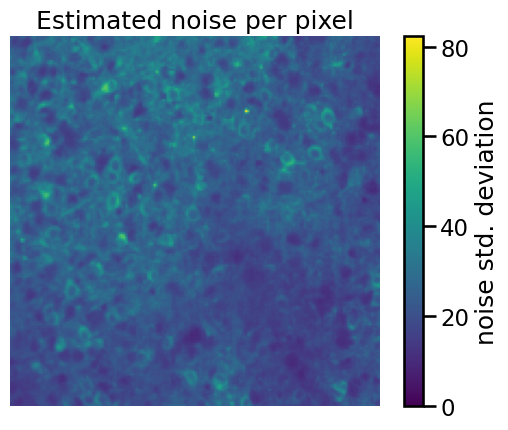

In [23]:
# High-pass filter the data at 8Hz using a Butterworth filter.
# That should filter out the calcium transients and give a
# reasonable estimate of the noise.

###
# YOUR CODE BELOW
sos = butter(N=10, Wn=8, btype='hp', output='sos', fs=30)
noise = sosfilt(sos, data, axis = 2)
noise = torch.tensor(noise, dtype=torch.float32) # convert to tensor
sigmas = torch.std(noise, axis = 2)
###
assert sigmas.shape == (height, width)

# Plot the noise standard deviation for each pixel
plt.imshow(sigmas, vmin=0)
plt.axis("off")
plt.title("Estimated noise per pixel")
plt.colorbar(label="noise std. deviation")

# Standardize the data by dividing each frame by the standard deviation
std_data = data / sigmas[:, :, None]

# Check that we got the same answer
assert torch.isclose(sigmas.mean(), torch.tensor(23.4807), atol=1e-4)

### Problem 1b: Find peaks in the local correlation matrix


**Step 1**
To find candidate neurons, look for places in the image where nearby pixels are highly correlated with one another.

The correlation between pixels $(i,j)$ and $(k,\ell)$ is

$$
\begin{align*}
\rho_{ijk\ell} = \frac{1}{T} \sum_{t=1}^T z_{ijt} z_{k\ell t},
\end{align*}
$$

where

$$
\begin{align*}
z_{ijt} = \frac{x_{ijt} - \bar{x}_{ij}}{\sigma_{ij}}
\end{align*}
$$

denotes the z-scored data (assume it is zero-padded), $x_{ijt}$ is the fluorescence at pixel $(ij)$ and frame $t$, $\bar{x}_{ij}$ is the average fluorescence at that pixel over time, and $\sigma_{ij}$ is the standard deviation of fluorescence in that pixel. You've already computed the noise level $\sigma_{ij}$ for each pixel and you computed $x_{ijt} / \sigma_{ij}$ in Problem 1a. To compute $z$, simply subtract the mean of the standardized data.

Now define the local correlation at pixel $(i,j)$ to be the average correlation with its neighbors to the north, south, east, and west:

$$
\begin{align*}
\bar{\rho}_{ij} = \tfrac{1}{4} \left(\rho_{ij,i+1,j} +  \rho_{ij,i-1,j} + \rho_{ij,i,j+1} + \rho_{ij,i,j-1}\right).
\end{align*}
$$

If $(i,j)$ is a border cell, assume the correlation with out-of-bounds neighbors is zero.

**Step 2**
Use the [`gaussian_filter`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.gaussian_filter.html) function with a standard deviation `sigma=NEURON_WIDTH/4` to smooth the local correlations.

**Step 3**
Find peaks in the smoothed local correlations using [`peak_local_max`](https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_peak_local_max.html),
which we imported from the `skimage.feature` package. Set a `min_distance`
of 2 and play with the `threshold_abs` to get 30 neurons, which we think is a reasonable estimate.

torch.Size([170, 170, 3000])
torch.Size([170, 170])
tensor(7.7494e-07)


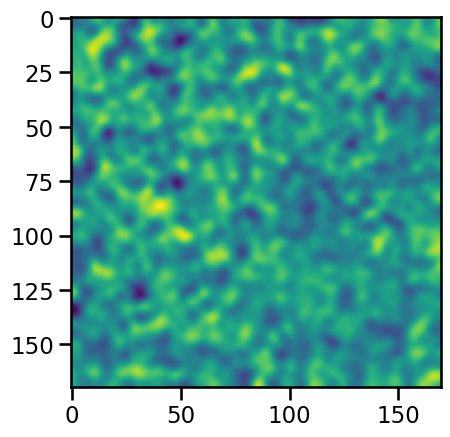

Found 30 candidate neurons


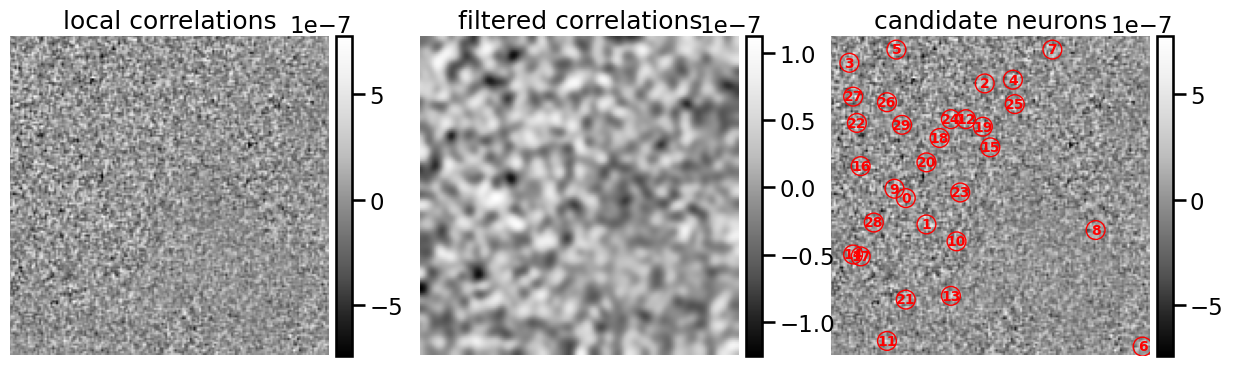

In [24]:
# First z-score the data
zscored_data = std_data - std_data.mean(dim=2, keepdims=True)

###
# YOUR CODE BELOW

# Compute the local correlation by summing correlations with
# neighboring pixels
local_correlations = torch.zeros((height, width))

print(zscored_data.shape)
print(local_correlations.shape)

local_correlations[:, :-1] += torch.mean(zscored_data[:, 1:, :] + zscored_data[:, :-1, :], axis = 2) # W
local_correlations[:,  1:] += torch.mean(zscored_data[:, :-1, :] + zscored_data[:, 1:, :], axis = 2) # E
local_correlations[:-1, :] += torch.mean(zscored_data[1:, :, :] + zscored_data[:-1, :, :], axis = 2) # S
local_correlations[1:,  :] += torch.mean(zscored_data[:-1, :, :] + zscored_data[1:, :, :], axis = 2) # N
local_correlations /= 4

print(local_correlations.max())

# Smooth the local correlations with a Gaussian filter of width 1/4
# the width of a typical neuron.
filtered_correlations = gaussian_filter(local_correlations, NEURON_WIDTH / 4)

plt.imshow(filtered_correlations)
plt.show()

# Finally, find peaks in the smoothed local correlations using
# `peak_local_max`. Set a `min_distance` of 2 and play with the
# `threshold_abs` to get 30 neurons, which we think is a reasonable estimate.
peaks = peak_local_max(filtered_correlations, threshold_abs = 6.7e-08, min_distance = 2)

#
###

num_neurons = len(peaks)
print("Found", num_neurons, "candidate neurons")
plot_problem_1d(local_correlations, filtered_correlations, peaks)
assert num_neurons == 30

### Problem 1c [Short Answer]: Explain this heuristic

Why are peaks in the local correlations indicative of neurons? Why did you filter the correlations? What would happen if you didn't use the Gaussian filter, or you used a Gaussian filter of a larger width?

---

Correlations suggest pixels are rising or falling in intensity together, which we would not expect for noise. We still need to filter though, because within a neuron is still noise. If we filter at the approximate number of pixels as a neuron, we should expect that neurons will be pulled out. If the width were too large, we would not find neurons again because more noise would be incorporated into the smoothing.

### Problem 1d: Initialize the footprints

It's easer to initialize the footprints in 2D, even though we will eventually ravel the video frames and footprints into vectors. Initialize the 2D footprint to,

$$
\begin{align*}
u_{k,i,j} \propto \mathcal{N}\left(\begin{bmatrix}i \\ j \end{bmatrix} \,\bigg|\, \begin{bmatrix} \mu_{k,i} \\ \mu_{k,j} \end{bmatrix}, \frac{w}{4} I \right)
\end{align*}
$$

where $\mu_{k} \in \mathbb{R}^2$ is the location of the peak for neuron $k$ and $w$ is the width of a typical neuron. These are the `peaks` you computed in the previous problem.

There's a simple trick to initialize the footprints: convolve a Gaussian filter with a matrix that is zeros everywhere except for a one at the location of the peak. The `gaussian_filter` function with `sigma` set to `NEURON_WIDTH/4` will do this for you.

Finally, normalize the footprints so that $\|\mathbf{u}_k\|=1$.

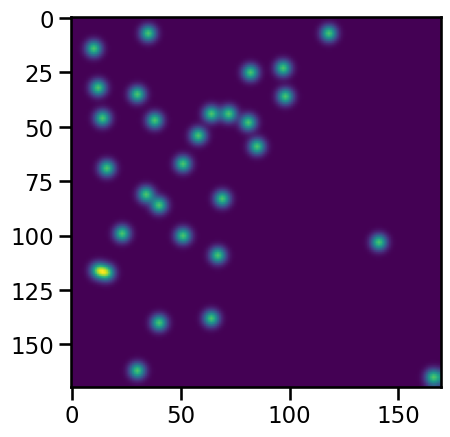

torch.Size([3000, 170, 170])


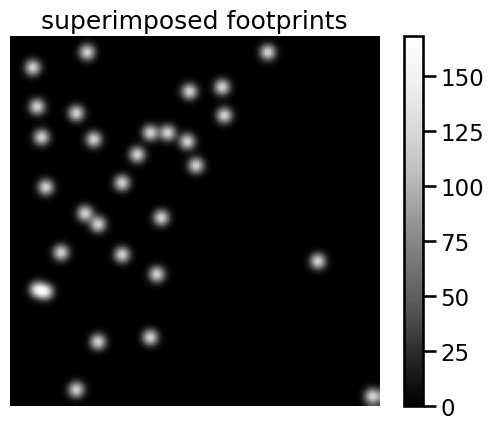

In [25]:
footprints = torch.zeros((num_neurons, height, width))

###

initialization = torch.zeros(170, 170)

for peak in peaks:
  initialization[peak[0], peak[1]] = 1

initialization_conv = torch.tensor(gaussian_filter(initialization, NEURON_WIDTH / 4))

norm = initialization_conv.norm(p=2)
initialization_conv = initialization_conv / norm

plt.imshow(initialization_conv)
plt.show()

footprints = initialization_conv.unsqueeze(0).repeat(3000, 1, 1)

print(footprints.shape)

###

# Check that they're unit norm
assert torch.allclose(torch.linalg.norm(footprints, axis=(1,2)), torch.tensor(1.0))

# Plot the superimpose footprints
plt.imshow(footprints.sum(axis=0), cmap="Greys_r")
plt.axis("off")
plt.title("superimposed footprints")
_ = plt.colorbar()

### Problem 1e: Initialize the background
Set the spatial background factor $\mathbf{u}_0$ equal to the **median of the standardized data** and set the temporal background factor to $\mathbf{c}_{0} = \mathbf{1}_T$. The median should be more robust to the large spikes than the mean is. Then normalize by dividing $\mathbf{u}_0$ by its norm $\|\mathbf{u}_0\|_2$ and multiplying $\mathbf{c}_0$ by $\|\mathbf{u}_0\|_2$.

In [26]:
print(zscored_data.median())

tensor(-0.2098)


In [27]:
np.median(zscored_data, axis = 2).shape

(170, 170)

torch.Size([3000])
torch.Size([170, 170])
tensor(0.0057)
tensor(358.4527)


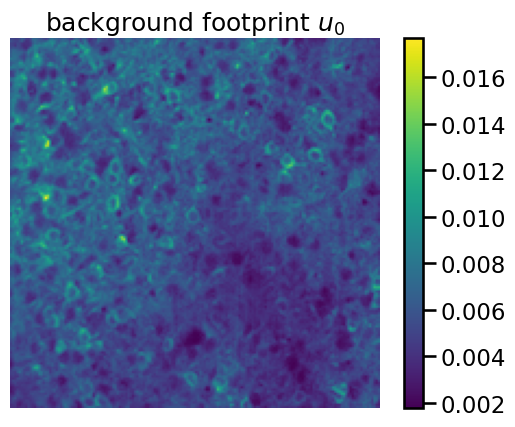

In [33]:
###
# Initialize the background footprint as described above

bkgd_footprint = torch.median(std_data, dim = 2).values
bkgd_trace = torch.ones(std_data.shape[2])

print(bkgd_trace.shape)

# Rescale so that spatial background is norm 1

norm = np.linalg.norm(bkgd_footprint)
bkgd_footprint = bkgd_footprint / norm

print(bkgd_footprint.shape)
print(bkgd_footprint.mean())

bkgd_trace = bkgd_trace * norm
print(bkgd_trace.mean())

###

# Plot the background factor
plt.imshow(bkgd_footprint)
plt.axis("off")
plt.title("background footprint $u_0$")
plt.colorbar()

assert torch.isclose(bkgd_footprint.mean(), torch.tensor(0.0056), atol=1e-4)
assert torch.isclose(bkgd_trace.mean(), torch.tensor(358.4527), atol=1e-4)

### Initialize the traces

We'll initialize the traces for Part 2 by computing the residual, projecting it onto each footprint in order, and updating the residual by subtracting off each neuron's contribution.

If we've done a good job initializing, the traces should show clear spikes and the noise should be roughly in the range $[-3, +3]$ since the data is standardized to have standard deviation 1.

In [46]:
bkgd_trace.shape

torch.Size([3000])

In [48]:
std_data.shape

torch.Size([170, 170, 3000])

In [34]:
# This code takes about a minute to run
residual = std_data - torch.einsum('ij,t->ijt', bkgd_footprint, bkgd_trace)
traces = torch.zeros((num_neurons, num_frames))
for k in trange(num_neurons):
    traces[k] = torch.einsum('ij,ijt->t', footprints[k], residual)
    residual -= torch.einsum('ij,t->ijt', footprints[k], traces[k])

  0%|          | 0/30 [00:00<?, ?it/s]

In [41]:
print(residual.shape, traces.shape)

torch.Size([170, 170, 3000]) torch.Size([30, 3000])


tensor(-1.4760e-08)


AssertionError: 

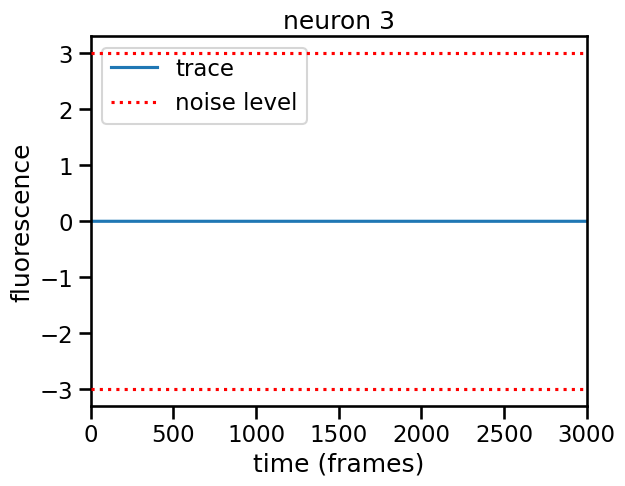

In [40]:
# Plot trace for a single neuron
k = 3
plt.plot(traces[k], label="trace")
plt.hlines([-3, 3], 0, num_frames,
        colors='r', linestyles=':', zorder=10,
        label="noise level")
plt.legend(loc="upper left")
plt.xlim(0, num_frames)
plt.xlabel("time (frames)")
plt.ylabel("fluorescence")
plt.title("neuron {}".format(k))

print(traces[3].mean())

# check that we got the same answer using the parameters from parts 1a-1e.
assert torch.isclose(traces[3].mean(), torch.tensor(2.3482))

## Part 2: Deconvolving spikes from calcium traces

In this part you'll use [CVXpy](https://www.cvxpy.org/) to deconvolve the calcium traces by solving a convex optimization problem. CVX is a "Python-embedded modeling language for convex optimization problems," as the website says.  It provides an easy-to-use interface for translating convex optimization problems into code and easy access to a variety of underlying solvers. The key objects are:
- `cvx.Variable` objects, which specify the variables you wish to optimize with respect to,
- `cvx.Minimize` objects, which let you specify the objective you wish to minimize,
- `cvx.Problem` objects, which combine an objective and a set of constraints.

CVX also has lots of helper functions like
- `cvx.sum_squares`, which computes the sum of squares of an array, and
- `cx.norm`, which computes norms of the specified order.

The following example is modified from the CVXpy homepage, linked above. It solves a least-squares problem with box constraints and compares the constrained and unconstrained solutions.

_Note: CVXpy is typically used with NumPy arrays, but it can operate on PyTorch tensors too. We'll just have to remember to convert the results back into tensors in subsequent steps._

In [ ]:
# A simple CVX example...

# Problem data.
torch.manual_seed(1)
A = dist.Normal(0.0, 1.0).sample((30, 20))
b = dist.Normal(0.0, 1.0).sample((30,))

# Construct the problem.
x = cvx.Variable(20)
objective = cvx.Minimize(cvx.sum_squares(A @ x - b))
constraints = [0 <= x, x <= 1]
prob = cvx.Problem(objective, constraints)

# The optimal objective value is returned by `prob.solve()`.
# The optimal value for x is stored in `x.value`.
result = prob.solve(verbose=False)

# Plot the constrained optimum vs the unconstrained.
plt.fill_between([0, 19], 0, 1, color='k', alpha=0.1, hatch='x',
                 label="constraint set")
plt.plot(x.value, '-o', label="$0 \leq x \leq 1$")
plt.plot(torch.linalg.lstsq(A, b, rcond=None)[0], '-', marker='.',
         label="unconstrained")
plt.xlim(0, 19)
plt.ylim(-1, 1.0)
plt.xlabel("$n$")
plt.ylabel("$x_n^\star$")
plt.legend(loc="lower right", fontsize=10)

### Problem 2a: Solve the convex optimization problem in dual form with CVX

In this part of the lab you'll use CVXpy to maximize the log joint probability in its **dual form:**

$$
\begin{align*}
    \hat{\mathbf{c}}_k, \hat{b}_k = \text{arg min}_{\mathbf{c}_k, b_k} \; \|\mathbf{G} \mathbf{c}_k\|_1
    \quad \text{subject to } \quad
    \|\boldsymbol{\mu}_k - \mathbf{c}_k - b_k\|_2^2 &\leq \theta^2, \; \mathbf{G} \mathbf{c}_k \geq 0,
\end{align*}
$$

where $\boldsymbol{\mu}_k = \mathbf{u}_k^\top \mathbf{R} \in \mathbb{R}^T$ is the target for neuron $k$ and

$$
\begin{align*}
    \mathbf{G} &=
    \begin{bmatrix}
    1             &               &        &        \\
    -e^{-1/\tau} & 1             &        &        \\
    0             & -e^{-1/\tau} & 1      &        \\
                  & 0             & \ddots & \ddots \\
    \end{bmatrix}
\end{align*}
$$

is the first order difference matrix. The spike amplitudes (i.e. jumps in the fluorescence) are given by $\mathbf{a}_k = \mathbf{G} \mathbf{c}_k$, so you can think about the optimization problem as minimizing the $L^1$ norm of the jumps subject to a non-negativity constraint and an upper bound on the $L^2$ norm of the difference between the target $\boldsymbol{\mu}_k$ and the trace $\mathbf{c}_k$.

**Note** that this is a slight modification of the problem presented in class:
1. Here we've added a bias term $b_k$, which will be helpful in cases where the target has a nonzero baseline.  Accounting for this possibility will lead to more robust estimates of the calcium traces.
2. In class we presented the constraint $\|\boldsymbol{\mu}_k - \mathbf{c}_k -b\|_2 \leq \theta$. CVXpy does a much better job at solving these "second order cone programs," so in practice that's what you should do! For this problem, however, you'll square both sides, as written in the objective above. Squaring doesn't change the constraint set, but it will make it easier to compare to the "primal" form you'll solve in Problem 2d and 2e.

We argued that a reasonable guess for the norm threshold is $\theta = (1+\epsilon) \sigma \sqrt{T}$.  For large $T$ and good estimates of the target, we should be able to set $\epsilon$ pretty small.  Here, we'll use a fairly liberal upper bound since we're working with a short dataset and a poor initial guess.

One of the great things about CVXpy is that it **works with SciPy's sparse matrices.** For example, you can use `scipy.sparse.diags` to construct the $\mathbf{G}$ matrix. Under the hood, the solver will leverage the sparsity to run in linear time.

In [ ]:
def deconvolve(
    trace: Union[np.ndarray, Float[torch.Tensor, "T"]],
    noise_std: float = 1.0,
    epsilon: float = 1.0,
    tau: float = GCAMP_TIME_CONST_SEC * FPS,
    full_output: bool = False,
    verbose: bool = False) -> Union[torch.Tensor, Dict[str, Any]]:
    """
    Deconvolve a noisy calcium trace (aka "target") by solving a convex optimization problem.

    Parameters
    ----------
    trace : np.ndarray [should work with torch.Tensor too]
        A T numpy array containing the noisy trace.
    noise_std : float
        Scalar noise standard deviation ($\sigma$). Default is 1.0.
    epsilon : float
        Extra slack for the norm constraint (typically > 0 and certainly > -1).
         Default is 1.0.
    tau : float
        The time constant of the calcium indicator decay.
        Default is GCAMP_TIME_CONST_SEC * FPS.
    full_output : bool
        If True, returns a dictionary with the deconvolved trace and additional information;
        otherwise returns only the deconvolved trace. Default is False.
    verbose : bool
        Flag to pass to the CVX solver to print more information.
        Default is False.

    Returns
    -------
    Union[torch.Tensor, Dict[str, Any]]
        Either a torch.Tensor representing the deconvolved trace, or a dictionary containing:
          - "trace": the deconvolved trace,
          - "baseline": the optimized baseline,
          - "result": the solver result,
          - "amplitudes": the convolution G @ trace,
          - "lagrange_multiplier": the dual value for the norm constraint.
    """
    assert trace.ndim == 1
    T = len(trace)

    ###
    # YOUR CODE BELOW

    # Initialize the variable we're optimizing over
    c = cvx.Variable(...)
    b = cvx.Variable(...)

    # Create the sparse matrix G with 1 on the diagonal and
    # -e^{-1/\tau} on the first lower diagonal
    G = ...

    # set the threshold to (1+\epsilon) \sigma \sqrt{T}
    theta = ...

    # Define the objective function
    objective = cvx.Minimize(...)

    # Set the constraints.
    # PUT THE NORM CONSTRAINT FIRST, THEN THE NON-NEGATIVITY CONSTRAINT!
    constraints = [..., ...]

    # Construct the problem
    prob = cvx.Problem(..., ...)
    ###

    # Solve the optimization problem.
    try:
        # First try the default solver then revert to SCS if it fails.
        result = prob.solve(verbose=verbose)
    except Exception as e:
        print("Default solver failed with exception:")
        print(e)
        print("Trying 'solver=SCS' instead.")
        # if this still fails we give up!
        result = prob.solve(verbose=verbose, solver="SCS")

    # Make sure the result is finite (i.e. it found a feasible solution)
    if torch.isinf(torch.tensor(result)):
        raise Exception("solver failed to find a feasible solution!")

    all_results = dict(
        trace=c.value,
        baseline=b.value,
        result=result,
        amplitudes=G @ c.value,
        lagrange_multiplier=constraints[0].dual_value[0]
    )
    assert torch.numel(torch.tensor(constraints[0].dual_value)) == 1, \
        "Make sure your first constraint is on the norm of the residual."

    return all_results if full_output else c.value

# Solve the deconvolution problem for one neuron
k = 3              # this neuron has particularly high SNR
noise_std = 1.0     # \sigma is 1 since we standardized the data
epsilon = 1.0       # start with a generous tolerance of 2 \sigma \sqrt{T}
dual_results = deconvolve(traces[k],
                          noise_std=noise_std,
                          epsilon=epsilon,
                          full_output=True,
                          verbose=True)

# Plot
plt.plot(traces[k], color=palette[0], lw=1, alpha=0.5, label="raw")
plt.plot(dual_results["trace"] + dual_results["baseline"],
         color=palette[0], lw=2, label="deconvolved")
plt.legend(loc="upper left")
plt.xlim(0, num_frames)
plt.xlabel("time (frames)")
plt.ylabel("fluorescence")
_ = plt.title("neuron {}".format(k))

# Check your answer
assert torch.isclose(torch.tensor(dual_results["result"], dtype=torch.float32),
                     torch.tensor(563.4), 1e-1)

### Plot solutions for a range of $\epsilon$ (and hence of $\theta$)


Compute and plot the solutions (in separate figures) for a range of $\epsilon$ values.

In [ ]:
epsilons = [0, 0.25, 0.5, 0.75, 1, 2]
for epsilon in epsilons:
    print("solving with epsilon = ", epsilon)

    # deconvolve with this epsilon
    dual_results = deconvolve(traces[k],
                              noise_std=noise_std,
                              epsilon=epsilon,
                              full_output=True,
                              verbose=False)

    # Plot
    plt.figure()
    plt.plot(traces[k], color=palette[0], lw=1, alpha=0.5, label="raw")
    plt.plot(dual_results["trace"] + dual_results["baseline"],
            color=palette[0], lw=2, label="".format(epsilon))
    plt.legend(loc="upper left", fontsize=10)
    plt.xlim(0, num_frames)
    plt.xlabel("time (frames)")
    plt.ylabel("fluorescence")
    _ = plt.title("neuron {} $\epsilon$ = {:.2f}".format(k, epsilon))


### Problem 2b [Short Answer]: Explain these results

How does the solution change as you increase $\epsilon$ and thereby increase $\theta$? Why?

---


_Your answer here_


### Problem 2c [Math]: Relate the dual form to the primal

Replacing the upper bound on the squared norm in Problem 2a with its Lagrangian, we obtain the following "primal" form of the problem:

$$
\begin{align*}
    \hat{\mathbf{c}}_k, \hat{b}_k = \text{arg min}_{\mathbf{c}_k, b_k} \; \eta (\|\boldsymbol{\mu}_k - \mathbf{c}_k - b_k\|_2^2 - \theta^2) + \|\mathbf{G} \mathbf{c}_k\|_1
    \quad \text{subject to } \quad  \mathbf{G} \mathbf{c}_k \geq 0,
\end{align*}
$$

where $\eta$ is the Lagrange multiplier.

**Show** that this is equivalent to maximizing the log joint (with a baseline $b_k$)

$$
\begin{align*}
\hat{\mathbf{c}}_k, \hat{b}_k = \text{arg max}_{\mathbf{c}_k, b_k} \mathcal{L}(\mathbf{c}_k, b_k) &= -\frac{1}{2\sigma^2} \|\boldsymbol{\mu}_k - \mathbf{c}_k - b_k\|_2^2 - \lambda_k\|\mathbf{G} \mathbf{c}_k\|_1 \quad \text{subject to } \quad  \mathbf{G} \mathbf{c}_k \geq 0
\end{align*}
$$

by **solving for the value of $\lambda_k$** (in terms of $\eta$ and $\sigma$) that makes these problems equivalent.

---


_Your answer here_

### Problem 2d: Solve the problem in primal form with $\lambda_k$ set to match the dual

Solve the primal problem with CVX using the amplitude rate hyperparameter $\lambda_k$ that you solved for in Problem 2d and the optimal Lagrange multiplier $\eta$ output in Problem 2a. In code,

```
dual_results["lagrange_multiplier"]   # this is \eta
```

In [ ]:
def deconvolve_primal(
    trace: Union[np.ndarray, Float[torch.Tensor, "T"]],
    amplitude_rate: float,
    noise_std: float = 1.0,
    tau: float = GCAMP_TIME_CONST_SEC * FPS,
    verbose: bool = True,
    full_output: bool = False) -> Union[torch.Tensor, Dict[str, Any]]:
    """
    Deconvolve a noisy calcium trace (aka "target") by solving
     a convex optimization problem in the primal form.

    Parameters
    ----------
    trace : np.ndarray [should work with torch.Tensor too]
        A T numpy array containing the noisy trace.
    amplitude_rate : float
        Non-negative rate (inverse scale) parameter $\lambda$.
    noise_std : float, optional
        Scalar noise standard deviation ($\sigma$). Default is 1.0.
    tau : float, optional
        The time constant of the calcium indicator decay.
         Default is GCAMP_TIME_CONST_SEC * FPS.
    verbose : bool, optional
        Flag to pass to the CVX solver to print additional information.
        Default is True.
    full_output : bool, optional
        If True, returns a dictionary with the deconvolved trace and additional information; otherwise, returns only the deconvolved trace. Default is False.

    Returns
    -------
    Union[torch.Tensor, Dict[str, Any]]
        Either a torch.Tensor representing the deconvolved trace, or a dictionary containing:
            - "trace": the deconvolved trace,
            - "baseline": the optimized baseline,
            - "result": the solver result,
            - "amplitudes": the computed spike amplitudes (G @ c.value).
    """
    assert trace.ndim == 1
    T = len(trace)

    ###
    # YOUR CODE BELOW

    # Initialize the variable we're optimizing over
    c = cvx.Variable(...)
    b = cvx.Variable(...)

    # Create the sparse matrix G with 1 on the diagonal and
    # -e^{-1/\tau} on the first lower diagonal
    G = ...

    # Define the objective function
    objective = cvx.Minimize(...)
    constraints = [...]
    prob = cvx.Problem(...)
    ###

    # Solve the optimization problem
    result = prob.solve(verbose=verbose)
    if torch.isinf(torch.tensor(result)):
        raise Exception("solver failed to find a feasible solution!")

    all_results = dict(
        trace=c.value,
        baseline=b.value,
        result=result,
        amplitudes=G @ c.value
    )
    return all_results if full_output else c.value


# Solve the deconvolution problem in the dual form
k = 3               # this neuron has particularly high SNR
noise_std = 1.0     # \sigma is 1 since we standardized the data
epsilon = 1.0       # start with a generous tolerance \epsilon = 1
dual_results = deconvolve(traces[k],
                          noise_std=noise_std,
                          epsilon=epsilon,
                          full_output=True,
                          verbose=True)

###
# Convert the optimal Lagrange multiplier returned in Problem 2a
# to a hyperparameter $\lambda_n$ that sets the rate (inverse scale)
# of the exponential prior on spike amplitudes. The multiplier `eta` is in
# `dual_results['lagrange_multiplier']` and \sigma is set by `noise_std`.
#
# YOUR CODE BELOW
amplitude_rate = ...
###


# Solve the problem in primal form
primal_results = deconvolve_primal(traces[k],
                                   amplitude_rate=amplitude_rate,
                                   verbose=True,
                                   full_output=True)

# Plot raw, primal, and dual optimal trace for neuron n
plt.plot(traces[k], color=palette[0], lw=1, alpha=0.5, label="raw")
plt.plot(dual_results["trace"] + dual_results["baseline"],
         color=palette[0], ls='-', lw=2, label="dual")
plt.plot(primal_results["trace"] + primal_results["baseline"],
         color=palette[1], ls='-', lw=1, label="primal")
plt.legend(loc="upper left")
plt.xlim(0, num_frames)
plt.xlabel("time (frames)")
plt.ylabel("fluorescence")
plt.title("neuron {}".format(k))

# Make sure the traces are the same!
primal_diff = abs(dual_results["trace"] - primal_results["trace"]).max()
print("primal and dual solutions match to absolute value: {:.4f}".format(primal_diff))
assert torch.allclose(torch.tensor(dual_results["trace"]),
                      torch.tensor(primal_results["trace"]),
                      atol=1e-1)


### Compute all deconvolved traces and plot them

In [ ]:
# Deconvolve each trace and concatenate the results
deconvolved_traces = torch.zeros_like(traces)
amplitudes = torch.zeros_like(traces)
for neuron in trange(num_neurons):
    all_results = deconvolve(traces[neuron], epsilon=0.9, full_output=True)
    deconvolved_traces[neuron] = torch.tensor(all_results["trace"],
                                              dtype=torch.float32)
    amplitudes[neuron] = torch.tensor(all_results["amplitudes"],
                                      dtype=torch.float32)

In [ ]:
plot_problem_2(traces, deconvolved_traces, amplitudes)

## Part 3: Demix and deconvolve the calcium imaging video

In this part you'll write the updates for MAP estimation in the constrained non-negative matrix factorization model.

As in the notes and slides, we will operate on the **flattened** data and residuals by reshaping the frames into 1d vectors.

**Note** that unlike CNMF (Pnevmatikakis et al, 2016), we're not going to constrain the footprints to be non-negative. Instead, we'll just assume they are normalized, since that's a bit easier to and it makes a clearer connection to the spike sorting algorithms from the previous lab. It would be a simple extension to enforce non-negativity, and the course notes describe how.

### Flatten the pixel dimensions and package the parameters

In [ ]:
flat_data = std_data.reshape(-1, num_frames)
flat_footprints = footprints.reshape(num_neurons, -1)
flat_bkgd_footprint = bkgd_footprint.reshape(-1)

# Package the paramters into a dictionary
params = dict(
    traces=torch.zeros((num_neurons, num_frames)),  # C
    bkgd_trace=bkgd_trace,                          # c_0
    footprints=flat_footprints,                     # U
    bkgd_footprint=flat_bkgd_footprint              # u_0
)

# Move the data and params to the GPU
flat_data = flat_data.to(device)
for key in params.keys():
    params[key] = params[key].to(device)

# The hyperparameters specify the number of neurons,
# the noise standard deviation ($\sigma = 1$ since we standardized the data),
# the prior variance of the background trace (something really large),
# and the tolerance for our norm constrain ($\epsilon$).
hypers = dict(
    num_neurons=num_neurons,
    noise_std=1.0,
    bkgd_trace_var=1e6,
    epsilon=1.0,
)

### Problem 3a: Write a function to compute the log likelihood given the residual

The log likelihood is

$$
\begin{align*}
\log p(\mathbf{X} \mid \mathbf{U}, \mathbf{C}) &=
\sum_{n=1}^N \sum_{t=1}^T \log \mathcal{N}\left(x_{n,t} \,\bigg|\, \sum_{k=0}^K u_{k,n} c_{k,t}, \sigma^2 \right) \\
\end{align*}
$$

Write a function to compute the log likelihood given the precomputed residual $\mathbf{R} = \mathbf{X} - \mathbf{U} \mathbf{C}^\top $.

_Hint: Use `dist.Normal`'s `log_prob` function._


In [ ]:
def log_likelihood_residual(
    residual: Float[torch.Tensor, "N T"],
    hypers: Dict[str, Any]) -> torch.Tensor:
    """
    Evaluate the log joint probability of the data given the precomputed residual.

    The residual represents the difference between the observed data and the contributions
    of the neurons and background, i.e. Y - U^T C - u_0 c_0^T.

    Parameters
    ----------
    residual : torch.Tensor
        A tensor of shape (N, T) containing the residual noise after subtracting the neuron
        and background contributions.
    hypers : dict
        A dictionary of hyperparameters.

    Returns
    -------
    torch.Tensor
        A scalar tensor containing the normalized log likelihood (i.e. divided by the number
        of residual elements).
    """
    ###
    # YOUR CODE HERE
    lp = ...
    ###
    return lp / residual.numel()

# check it on the flat data (as if C and c_0 were zero)
assert torch.isclose(
    log_likelihood_residual(flat_data, hypers),
    torch.tensor(-4.6855), atol=1e-4)

### Problem 3b: Optimize a trace

Optimize a single neuron's trace using the `deconvolve` function you wrote in Problem 2a. The target is $\boldsymbol{\mu}_k = \mathbf{u}_k^\top \mathbf{R}_k$ where $R_k$ is the residual for this neuron. The residual is given as input to this function.

**Note:** In your final version, make sure you have `verbose=False` so that the final code doesn't print a bunch of unnecessary stuff.

In [ ]:
def _update_trace(
    neuron: int,
    residual: Float[torch.Tensor, "N T"],
    params: Dict[str, torch.Tensor],
    hypers: Dict[str, Any]) -> Float[torch.Tensor, "T"]:
    """
    Update a single neuron's trace by deconvolving the corresponding residual.

    Parameters
    ----------
    neuron : int
        The index of the neuron to update.
    residual : torch.Tensor
        A tensor of shape (N, T) containing the residual for this neuron.
    params : dict
        A dictionary of parameters
    hypers : dict
        A dictionary of hyperparameters.

    Returns
    -------
    torch.Tensor
        The updated trace for the neuron as a tensor of shape (T,).
    """
    footprint = params["footprints"][neuron]

    ###
    # YOUR CODE BELOW
    target = ...
    target = target.to("cpu")    # Move to CPU so CVXPy can use it
    trace = deconvolve(...)
    ###

    # Move trace back to device before returning
    trace = torch.tensor(trace, device=device, dtype=torch.float32)
    assert torch.all(torch.isfinite(trace))
    return trace

### Problem 3c: Optimize a footprint

Optimize a single neuron's footprint by setting it to $\mathbf{u}_k = \frac{\mathbf{R} \mathbf{c}_k}{\|\mathbf{R} \mathbf{c}_k\|}$  where $\mathbf{R}$ is the given residual and $\mathbf{c}_k$ is the neuron's trace.

In [ ]:
def _update_footprint(
    neuron: int,
    residual: Float[torch.Tensor, "N T"],
    params: Dict[str, torch.Tensor],
    hypers: Dict[str, Any]) -> Float[torch.Tensor, "F"]:
    """
    Update a single neuron's footprint.

    Based on the current neuron trace (from params["traces"]) and the residual,
    compute a new, normalized spatial footprint for the neuron.

    Parameters
    ----------
    neuron : int
        The index of the neuron to update.
    residual : torch.Tensor
        A tensor of shape (N, T) representing the residual for this neuron.
    params : dict
        A dictionary of parameters containing "traces" and "footprints".
    hypers : dict
        A dictionary of hyperparameters.

    Returns
    -------
    torch.Tensor
        The updated, normalized footprint as a tensor of shape (F,).
        Its norm should be 1.
    """
    trace = params["traces"][neuron]

    ###
    # YOUR CODE BELOW
    footprint = ...
    ###

    assert torch.all(torch.isfinite(footprint))
    assert torch.linalg.norm(footprint).isclose(torch.tensor(1.0))
    return footprint


### Problem 3d: Optimize the background

Optimize the background trace by projecting the residual onto the background footprint and shrinking the result slightly,

$$
\begin{align*}
\mathbf{c}_0 = \left(\frac{\varsigma_0^2}{\sigma^2 + \varsigma_0^2}\right) \mathbf{u}_0^\top \mathbf{R}
\end{align*}
$$

where $\mathbf{R} = \mathbf{X} - \sum_{k=1}^K \mathbf{u}_k\mathbf{c}_k^\top $ is the background residual and $\varsigma_0^2$ is the prior variance on the background trace. (See the course notes for a derivation.)

Update the background footprint by setting it to,

$$
\begin{align*}
\mathbf{u}_0 = \frac{\mathbf{R} \mathbf{c}_0}{\|\mathbf{R} \mathbf{c}_0\|}
\end{align*}
$$

In [ ]:
def _update_bkgd_trace(
    residual: Float[torch.Tensor, "N T"],
    params: Dict[str, torch.Tensor],
    hypers: Dict[str, Any]) -> Float[torch.Tensor, "T"]:
    """
    Update the background trace $c_0$

    Parameters
    ----------
    residual : torch.Tensor
        A tensor of shape (N, T) containing the residual for the background.
    params : dict
        A dictionary of parameters including "bkgd_footprint" and "bkgd_trace".
    hypers : dict
        A dictionary of hyperparameters with keys including "noise_std" and "bkgd_trace_var".

    Returns
    -------
    torch.Tensor
        The updated background trace as a tensor of shape (T,).
    """
    sigmasq = hypers["noise_std"]**2
    sigmasq_prior = hypers["bkgd_trace_var"]
    footprint = params["bkgd_footprint"]

    ###
    # YOUR CODE BELOW
    shrink_factor = ...
    target = ...
    ###

    # update the latent variables in place
    return shrink_factor * target

def _update_bkgd_footprint(
    residual: Float[torch.Tensor, "N T"],
    params: Dict[str, torch.Tensor],
    hypers: Dict[str, Any]) -> Float[torch.Tensor, "F"]:
    """
    Update the background footprint $u_0$.

    Using the current background trace from params and the residual,
    compute a new background footprint and normalize it to unit norm.

    Parameters
    ----------
    residual : torch.Tensor
        A tensor of shape (N, T) containing the residual for the background.
    params : dict
        A dictionary of parameters including "bkgd_trace" and "bkgd_footprint".
    hypers : dict
        A dictionary of hyperparameters.

    Returns
    -------
    torch.Tensor
        The updated, normalized background footprint as a tensor of shape (F,).
    """
    bkgd_trace = params["bkgd_trace"]

    ###
    # YOUR CODE BELOW
    bkgd_footprint = ...
    ###

    assert torch.all(torch.isfinite(bkgd_footprint))
    assert torch.linalg.norm(bkgd_footprint).isclose(torch.tensor(1.0))
    return bkgd_footprint

## Putting it all together

Now we'll put these steps together into the MAP estimation algorithm. It's very similar to what you implemented in Lab 2. It amounts to:
- Initialize the residual $\mathbf{R} = \mathbf{X} - \mathbf{U} \mathbf{C}^\top$
- Repeat until convergence:
    - For each neuron $k=1,\ldots,K$:
        - Update the residual to $\mathbf{R} = \mathbf{R} + \mathbf{u}_k \mathbf{c}_k^\top$
        - Update the trace $\mathbf{c}_k$ by applying your `deconvolve` function from Part 2a to the target $\boldsymbol{\mu}_k = \mathbf{u}_k^\top \mathbf{R}$
        - Update the footprint to $\mathbf{u}_k = \frac{\mathbf{R} \mathbf{c}_k}{\|\mathbf{R} \mathbf{c}_k\|}$
        - Downdate the residual to $\mathbf{R} = \mathbf{R} - \mathbf{u}_k \mathbf{c}_k^\top$ using the new footprint and trace
    - Update the background:
        - Update the residual to $\mathbf{R} = \mathbf{R} + \mathbf{u}_0 \mathbf{c}_0^\top$
        - Set the background trace to $\mathbf{c}_0 = \frac{\varsigma_0^2}{\sigma^2 + \varsigma_0^2} \mathbf{u}_0^\top \mathbf{R}$ where $\varsigma_0^2$ is the prior variance of the background trace. (We will set it to be very large so that we barely shrink the background trace.)
        - Set the background footprint to $\mathbf{u}_0 = \frac{\mathbf{R} \mathbf{c}_0}{\|\mathbf{R} \mathbf{c}_0\|}$
        - Downdate the residual to $\mathbf{R} = \mathbf{R} - \mathbf{u}_0 \mathbf{c}_0^\top$ using the new background footprint and trace.
    - Compute the log likelihood using the residual $\mathbf{R}$


In [ ]:
def map_estimate(
    flat_data: Float[torch.Tensor, "F T"],
    params: Dict[str, torch.Tensor],
    hypers: Dict[str, Any],
    num_iters: int = 10,
    tol: float = 2e-4) -> Tuple[torch.Tensor, Dict[str, torch.Tensor]]:
    """
    Fit the CNMF model using coordinate ascent to obtain the maximum a posteriori estimate.

    The algorithm alternates between updating neuron traces, neuron footprints, and background
    components until convergence based on the log likelihood of the residual.

    Parameters
    ----------
    flat_data : torch.Tensor
        A tensor with shape (F, T) representing the flattened imaging data.
    params : dict
        A dictionary of parameters including:
            - "traces": Tensor of shape (num_neurons, T)
            - "bkgd_trace": Tensor of shape (T,)
            - "footprints": Tensor of shape (num_neurons, F)
            - "bkgd_footprint": Tensor of shape (F,)
    hypers : dict
        A dictionary of hyperparameters containing:
            - "num_neurons": int, the number of neurons.
            - "noise_std": float, the noise standard deviation.
            - "bkgd_trace_var": float, the prior variance for the background trace.
            - "epsilon": float, the tolerance for the norm constraint.
    num_iters : int, optional
        The maximum number of iterations for coordinate ascent.
        Default is 10.
    tol : float, optional
        The convergence tolerance on the change in log likelihood.
        Default is 2e-4.

    Returns
    -------
    Tuple[torch.Tensor, dict]
        A tuple containing:
            - A tensor of log likelihood values over iterations.
            - The updated parameter dictionary.
    """

    # make a fancy reusable progress bar for the inner loops over neurons.
    outer_pbar = trange(num_iters)
    inner_pbar = trange(hypers["num_neurons"])
    inner_pbar.set_description("updating neurons")

    # initialize the residual
    residual = torch.clone(flat_data)
    residual -= params["footprints"].T @ params["traces"]
    residual -= torch.outer(params["bkgd_footprint"], params["bkgd_trace"])

    # track log likelihoods over iterations
    lls = [log_likelihood_residual(residual, hypers)]
    outer_pbar.set_description("LL: {:.4f}".format(lls[-1]))

    # coordinate ascent
    for itr in outer_pbar:

        # update neurons one at a time
        inner_pbar.reset()
        for k in range(hypers["num_neurons"]):
            # update the residual (add $u_k c_k^\top$)
            residual += torch.outer(params["footprints"][k], params["traces"][k])

            # update the trace and footprint with the residual
            params["traces"][k] = _update_trace(k, residual, params, hypers)
            params["footprints"][k] = _update_footprint(k, residual, params, hypers)

            # downdate the residual (subtract $u_k c_k^\top$)
            residual -= torch.outer(params["footprints"][k], params["traces"][k])

            # step the progress bar
            inner_pbar.update()

        # update the background
        residual += torch.outer(params["bkgd_footprint"], params["bkgd_trace"])
        params["bkgd_trace"] = _update_bkgd_trace(residual, params, hypers)
        params["bkgd_footprint"] = _update_bkgd_footprint(residual, params, hypers)
        residual -= torch.outer(params["bkgd_footprint"], params["bkgd_trace"])

        # compute the log likelihood
        lls.append(log_likelihood_residual(residual, hypers))
        outer_pbar.set_description("LL: {:.4f}".format(lls[-1]))

        # check for convergence
        if abs(lls[-1] - lls[-2]) < tol:
            print("Convergence detected!")
            break

    return torch.stack(lls), params

### Fit it!

This should take about 2 minutes with a GPU backend.

**Note**: With the default setting of $\epsilon$, you will likely see the following warning:

```
Default solver failed with exception:
Solver 'ECOS' failed. Try another solver, or solve with verbose=True for more information.
Trying 'solver=SCS' instead.
/usr/local/lib/python3.8/dist-packages/cvxpy/problems/problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
```

When this happens, the SCS solver can take around 20 seconds to complete. For me, it only happens when updating neuron 28 in the first epoch.


In [ ]:
# Fit it!
lls, params = map_estimate(flat_data, params, hypers)

In [ ]:
# Plot the log likelihoods
plt.plot(lls.to("cpu"), '-o',)
plt.xlabel("Iteration")
plt.xlim(-.1, len(lls) - .9)
plt.ylabel("Log Likelihood")
plt.grid(True)

### Plot the inferred footprints and traces

In [ ]:
# Yes, we know we're creating a lot of figures...
warnings.filterwarnings("ignore")

for key in params.keys():
    params[key] = params[key].to("cpu")

plot_problem_3(flat_data, params, hypers)

### Make a movie of the data, reconstruction, and residual

Show a movie with the data, reconstruction, and residual side by side. If all goes well, the data should show a nice, clean movie of spiking neurons and the residual should mostly look like white noise. In practice, you'll probably still see some evidence of neurons in the residual, suggesting that the model still isn't perfect.

In [ ]:
###
# Reconstruct the data and compute the residual.
# Then make a movie of the data, reconstruction, and residual
# side-by-side.
#
flat_recon = params["footprints"].T @ params["traces"]
flat_recon += torch.outer(params["bkgd_footprint"], params["bkgd_trace"])
flat_residual = flat_data.to("cpu") - flat_recon

# Reshape into image stacks and concatenate along axis=1.
movie = torch.cat([
    flat_data.reshape(height, width, -1).to("cpu"),
    flat_recon.reshape(height, width, -1),
    flat_residual.reshape(height, width, -1),
    ], dim=1)

# Play the movie
play(movie, speedup=5)

## Part 4: Discussion

Hopefully you were successful in separating the neurons from the background and noise! Let's take a minute to reflect on the model and results.

### Problem 4a
 We mentioned a few times that actual CNMF implementations also constrain the footprints to be non-negative. Without this constraint, you probably found in the plots above (before Problem 3e) that some of these footprints contain negative values. Why is this unrealistic and what are the consequences of omitting this constraint?

 ---



Well, a cell cannot have a negative calcium concentration. Or, more explicitly the light emitted from GCAMP cannot be negative.

### Problem 4b

You probably noticed that the background has lots of rings in it, like little Cheerios. What could cause that effect?

---


These are effects due to the microscope. The issue is with photon capture and or photons spreading from the source.

### Problem 4c
We assumed that all neurons share the same time constant $\tau$. Is that reasonable? Without doing any math, describe how you would try to learn per-neuron time constants.

---


In this case, this is a fairly good assumption because the time constant of the GCAMP is likely longer than the firing rate of any neuron. If the GCAMP were faster acting, or the neuron were in very strange physiological conditions where the calcium levels persist or rise over time (maybe due to repeat firing or damage to the membrane), then this would not be as good of an assumption.

We could learn the per-neuron time constants simply by fitting an exponential decay function around the mean waveform of each neuron.

### Problem 4d
Do you think we can infer the number of underlying action potentials from the amplitude of the jumps in the calcium traces?  Why or why not?

---


I don't really understand what this question is asking, but for example: A rise in the baseline calcium would correspond to a higher number of spikes.

## Author contributions

Please write a short paragraph describing each authors contributions. Also please include any tools used or other people consulted.

---

I asked ChatGPT to help explain some questions to me. For example, I was a bit confused by what was meant by 1T for question 1e. No code was used from ChatGPT